# W207 Final Project

## Submission by Sirisha Bhupathi and Abhi Sharma

This project is for the Kaggle competition listed here: https://www.kaggle.com/c/facial-keypoints-detection

## Objective

The objective of this project is to predict keypoint positions on face images.

## Introduction

The image sizes are 96 x 96 pixels and the key points are represented as location co-ordinates for each image. 
Location co-ordinates can have 2 values - one for x and one for y. 
There are a total of 30 location co-ordinates per image, 15 each for the x and y axis.
Out of the 30 co-ordinates in the test dataset for a single image, some co-ordinates are present and others need to be predicted. 
The number and type of co-ordinates that need to be predicted vary per test example.


## Imports and Settings

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randint
import time
import math
import random

# import keras, tf and image depdencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import tensorflow_hub as hub
from tensorflow.keras import layers
from PIL import Image, ImageDraw, ImageOps, ImageEnhance
import cv2

In [2]:
# We verify if the GPU is working and available with the following commands
# Adapted from here: https://www.tensorflow.org/guide/gpu

tf_config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.compat.v1.Session(config=tf_config)
tf.compat.v1.keras.backend.set_session(s)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
#tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Physical devices cannot be modified after being initialized


## Data Loading

In [3]:
# Constants
IMG_DIM = 96
PIX_MAX = 255
IMAGE = 'Image'
COLUMNS = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']

CWD = '/project/notebooks'
AUGMENTATIONS = ["90R", "90L", "180H", "180V", "NoiseGaussian", "NoiseSaltPepper", "NoisePoisson", "NoiseSpeckle", "BrightDarkAug", "BlurAvg", "BlurGaussian", "MoveLeft", "MoveRight"]

In [4]:
folder_prefix = '..'
if os.getcwd() == CWD:
    folder_prefix = '/project/kaggle'

In [5]:
train = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/training.zip')
test = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/test.zip')
idlookup = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/IdLookupTable.csv')

In [6]:
print('Train shape:',train.shape)
print('Test shape:',test.shape)

Train shape: (7049, 31)
Test shape: (1783, 2)


In [7]:
train.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [8]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Data Validation

In [9]:
# Check for missing values
def check_missing_vals(data):
    return data.isnull().any().value_counts()
    
def fill_missing_with_col_mean(data):
    for col in COLUMNS:
        mean = np.mean(data[col])
        data[col] = data[col].fillna(mean)
    return data

In [10]:
check_missing_vals(train)

True     28
False     3
dtype: int64

In [11]:
check_missing_vals(test)

False    2
dtype: int64

In [12]:
train = fill_missing_with_col_mean(train)
check_missing_vals(train)

False    31
dtype: int64

## Feature Engineering and Augmentation

In [13]:
# Split image column and label columns

train_images = train[[IMAGE]]
train_labels = train.drop(IMAGE, axis=1)

train_labels.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [14]:
# Split train image pixels from string to 1 pixel per column and convert each pixel from string to float

train_images = train_images[IMAGE].str.split(' ', expand=True)
train_images = train_images.astype(float)

train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238.0,236.0,237.0,238.0,240.0,240.0,239.0,241.0,241.0,243.0,...,33.0,29.0,30.0,34.0,39.0,49.0,62.0,70.0,75.0,90.0
1,219.0,215.0,204.0,196.0,204.0,211.0,212.0,200.0,180.0,168.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,144.0,142.0,159.0,180.0,188.0,188.0,184.0,180.0,167.0,132.0,...,64.0,60.0,56.0,61.0,70.0,69.0,71.0,78.0,78.0,77.0
3,193.0,192.0,193.0,194.0,194.0,194.0,193.0,192.0,168.0,111.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,147.0,148.0,160.0,196.0,215.0,214.0,216.0,217.0,219.0,220.0,...,33.0,34.0,37.0,37.0,43.0,46.0,83.0,140.0,170.0,176.0


In [15]:
check_missing_vals(train_images)

False    9216
dtype: int64

In [16]:
check_missing_vals(train_labels)

False    30
dtype: int64

In [17]:
# Split test image pixels from string to 1 pixel per column and convert each pixel from string to float

test_images = test.copy()
test_images = test_images.set_index('ImageId')
test_images = test_images[IMAGE].str.split(' ', expand=True)
test_images = test_images.astype(float)

test_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
ImageId,,,,,,,,,,,,,,,,,,,,,
1,182.0,183.0,182.0,182.0,180.0,180.0,176.0,169.0,156.0,137.0,...,6.0,14.0,28.0,28.0,24.0,18.0,12.0,8.0,5.0,5.0
2,76.0,87.0,81.0,72.0,65.0,59.0,64.0,76.0,69.0,42.0,...,156.0,152.0,162.0,169.0,168.0,159.0,191.0,228.0,211.0,168.0
3,177.0,176.0,174.0,170.0,169.0,169.0,168.0,166.0,166.0,166.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,176.0,174.0,174.0,175.0,174.0,174.0,176.0,176.0,175.0,171.0,...,144.0,143.0,141.0,142.0,143.0,142.0,142.0,142.0,142.0,140.0
5,50.0,47.0,44.0,101.0,144.0,149.0,120.0,58.0,48.0,42.0,...,254.0,254.0,254.0,253.0,255.0,236.0,174.0,175.0,175.0,165.0


In [18]:
check_missing_vals(test_images)

False    9216
dtype: int64

In [19]:
num_train_examples = train_images.shape[0]
num_train_examples

7049

In [20]:
# Utility function to reshape image(s) to 2d
# Note that a dataframe is converted into a numpy array as a result of this transform
# Thus it is the user's responsibility to convert the array back to a dataframe if need be

def img_reshape_2d(data, width=IMG_DIM, height=IMG_DIM):
    data_2d = data.values.reshape(width, height)
    # returns data of shape (width, height)
    return data_2d

def multiple_img_reshape_2d(data, width=IMG_DIM, height=IMG_DIM):
    data_2d = data.values.reshape(-1, width, height, 1)
    # returns data of shape (rows, width, height, color channels)
    return data_2d

In [21]:
# Plot images and keypoints function
# if img_num is a valid value, we display that image only

def plot_images(train_images, train_labels, start_index=0, end_offset=1000, img_num=-1):
    rows = 4
    cols = 4
    multiplier = 10
    dot_size = 100
    
    if img_num != -1:
        dot_size = 50
        multiplier = 5
        rows = 1
        cols = 1
        
    fig = plt.figure(figsize=(rows * multiplier, cols * multiplier), constrained_layout = False)
    for i in range(1, cols * rows + 1):
        ax = fig.add_subplot(rows, cols, i)
        if img_num != -1:
            image_no = img_num
        else:
            image_no = randint(start_index, start_index+end_offset)
        img = np.array(train_images.iloc[image_no]).reshape(IMG_DIM, IMG_DIM)
        ax.imshow(img, cmap='gray')
        for j in range(0, 30, 2):
            ax.scatter(train_labels.iloc[image_no][j], train_labels.iloc[image_no][j+1], s=dot_size)
    plt.show()

    
def plot_image_with_label_optional(img, labels=pd.DataFrame()):
    fig = plt.figure(figsize=(5, 5), constrained_layout = False)
    # reshapes array in case it is given as flat representation, ie, 9216 pixels = 96 x 96 image
    img = np.array(img).reshape(IMG_DIM, IMG_DIM)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    if labels.empty == False:
        for j in range(0, 30, 2):
            ax.scatter(labels[j], labels[j+1], s=50)
    return fig

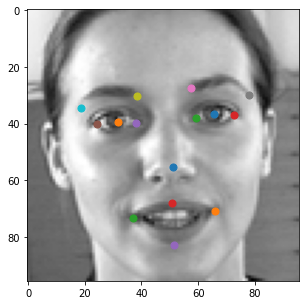

In [22]:
# Display single image giving index as input
plot_images(train_images, train_labels, img_num=20)

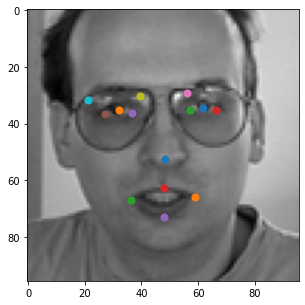

In [23]:
# Display another image directly giving image and label as input
plot_image_with_label_optional(train_images.iloc[155], train_labels.iloc[155]).show()

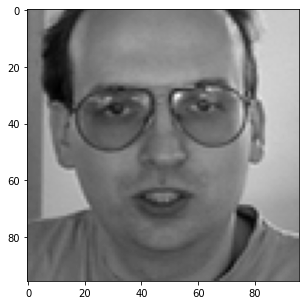

In [24]:
# Display same image without any labels
plot_image_with_label_optional(train_images.iloc[155]).show()

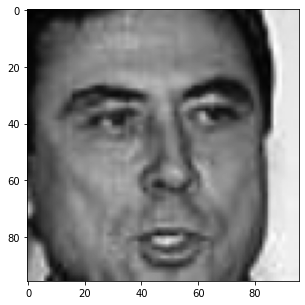

In [25]:
# Can plot some test images as well
# Plotting many of these we see that images are sometimes blurry + slightly translated (left or right)
plot_image_with_label_optional(test_images.iloc[990]).show()

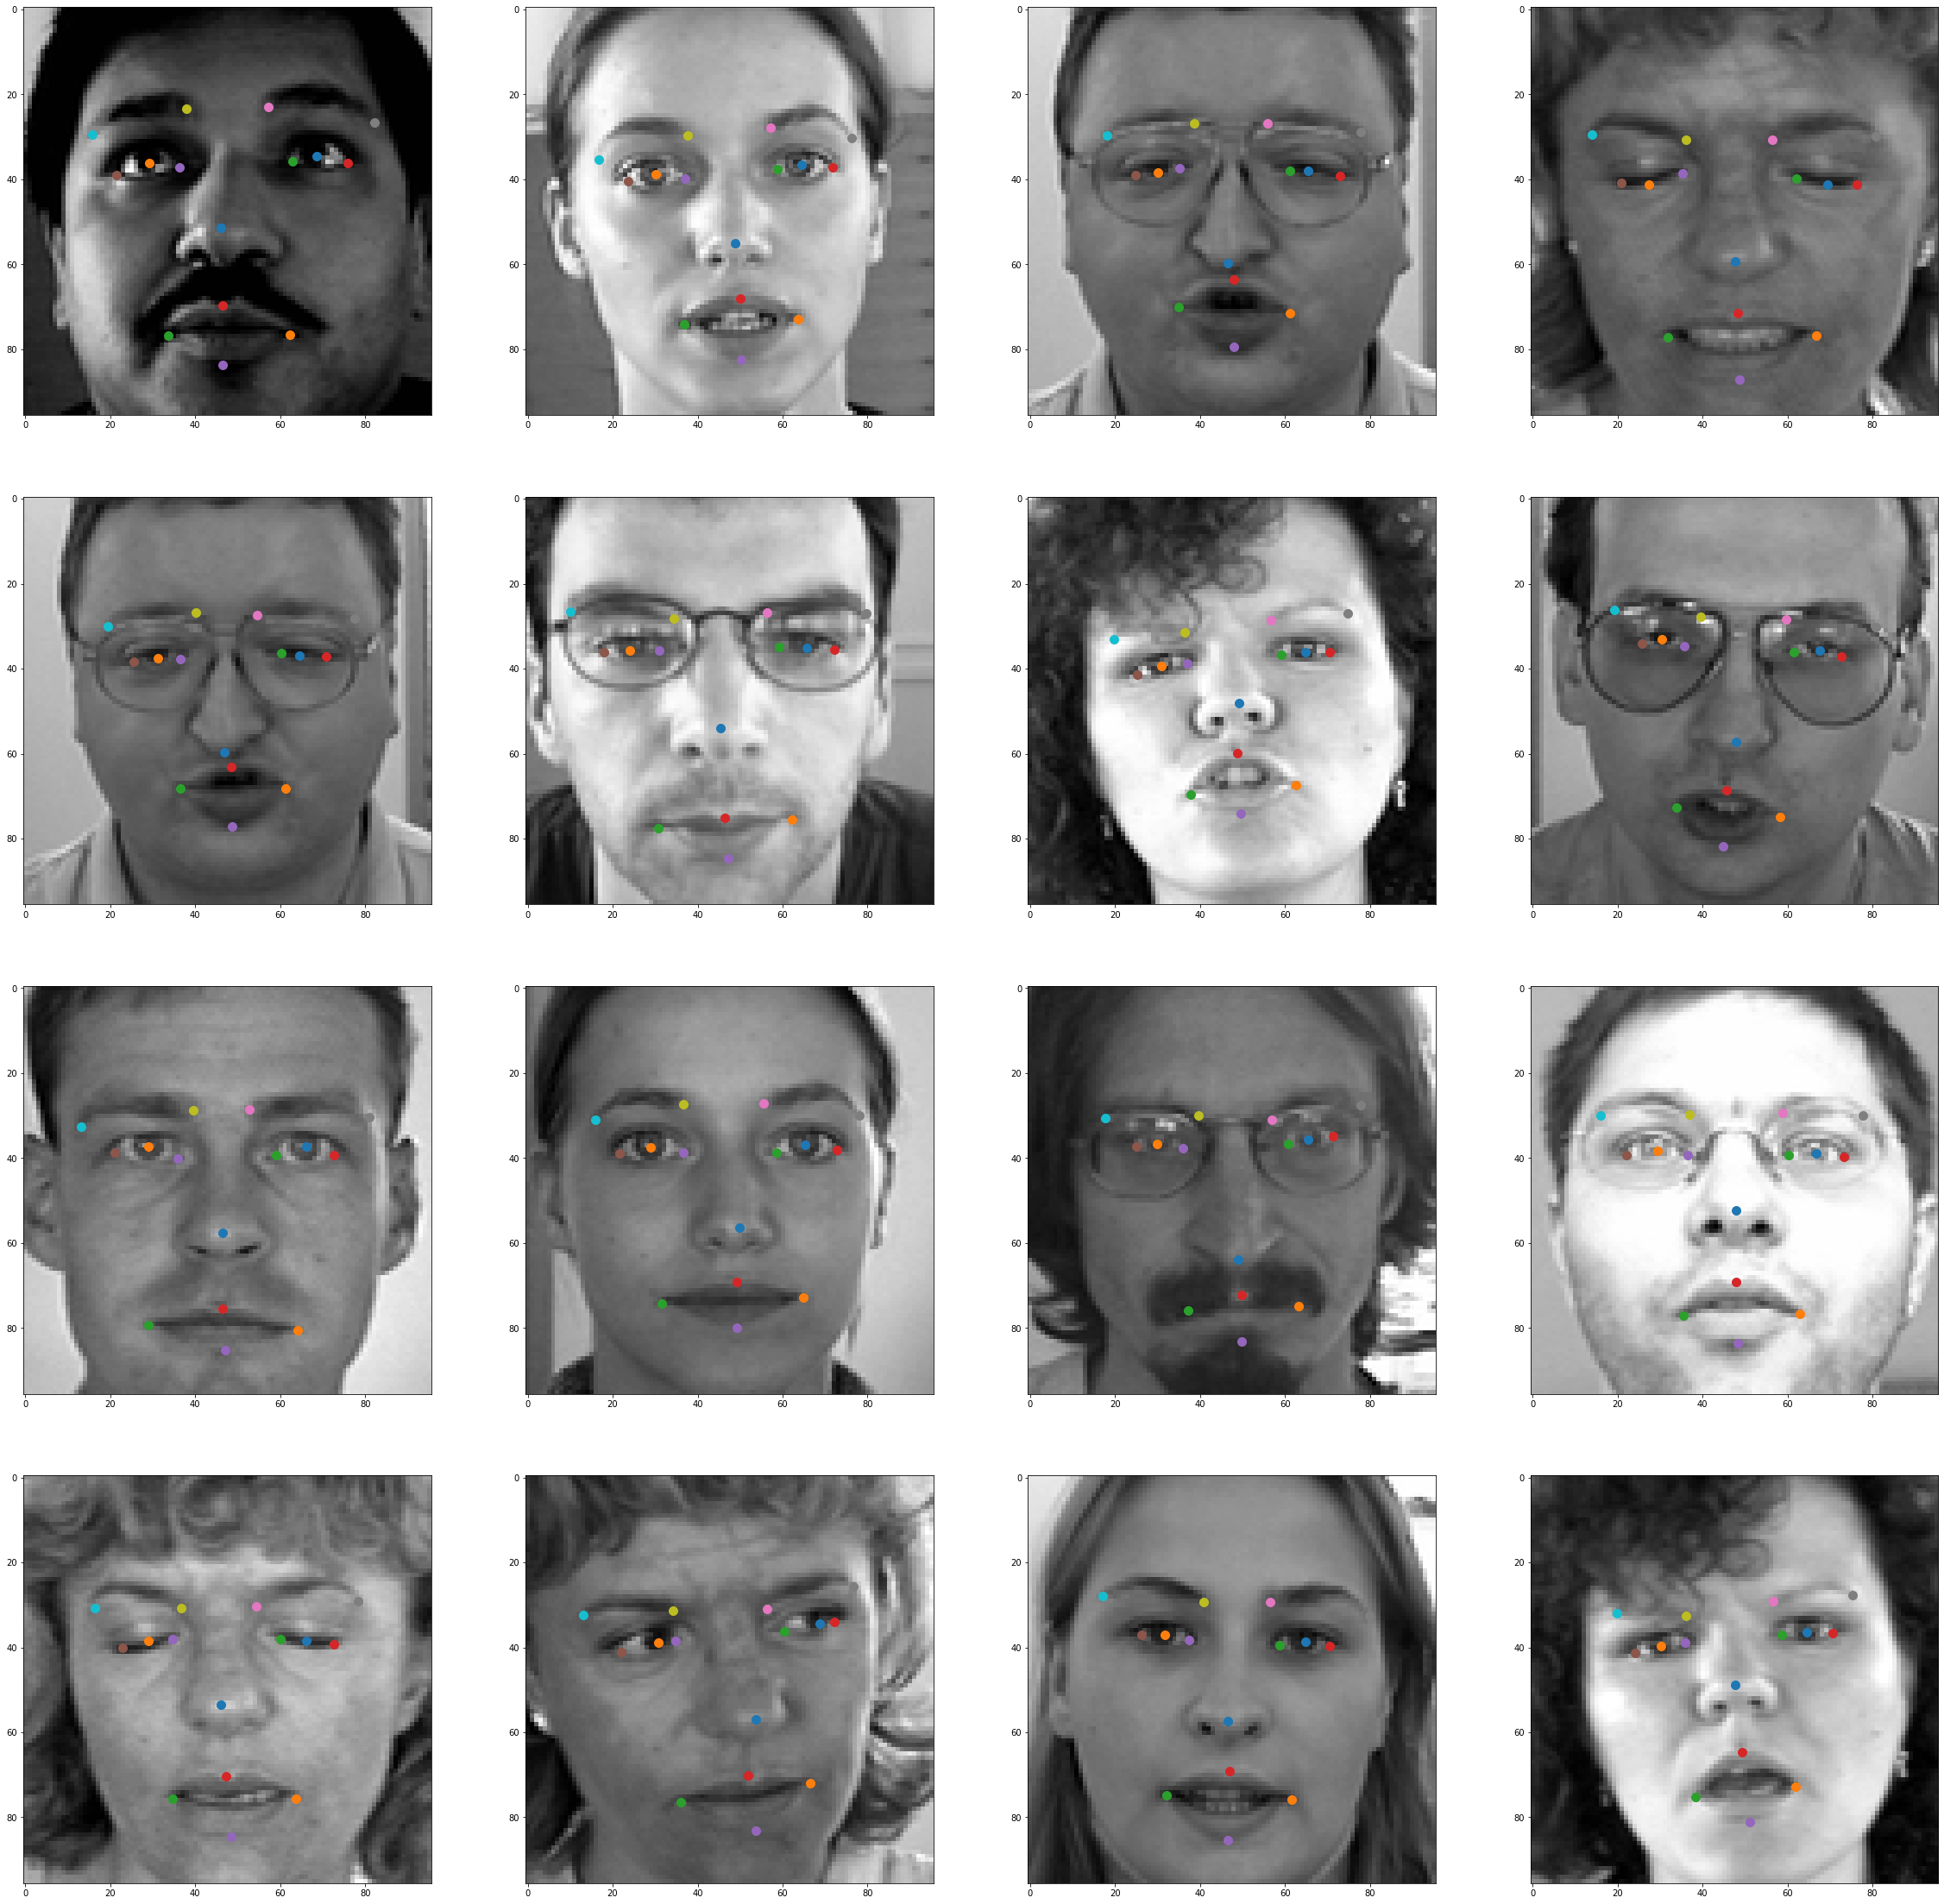

In [26]:
# Display many train images
plot_images(train_images, train_labels)

In [27]:
# Augmentation function to generate more images

def augment_images(train_img_set, train_label_set, aug_list):
    tick = time.perf_counter()
    for aug in aug_list:
        if aug not in AUGMENTATIONS:
            raise NameError("Augmentation -- {0} -- not valid".format(aug))
    
    if len(train_img_set) != len(train_label_set):
        raise ValueError("Train image set size must match label set size")
    
    output_imgs_flat = []
    output_imgs_2d = []
    output_label_set = []
    angle = 0
    for aug in aug_list:
        for idx, img in train_img_set.iterrows():

            labels = list(train_label_set.iloc[idx].copy())
            input_image = img.copy()
            if img.shape != (IMG_DIM, IMG_DIM):
                #print("Converting image to 2d")
                input_image = img_reshape_2d(input_image)

            output_image = Image.fromarray(input_image)
            if aug == "90R":
                # rotate 90 degrees to the right
                output_image = output_image.rotate(270)
                angle = 90
            elif aug == "90L":
                # rotate 90 degrees to the left
                output_image = output_image.rotate(90)
                angle = -90
            elif aug == "180H":
                # horizontal flip
                output_image = ImageOps.mirror(output_image)
                angle = 0
            elif aug == "180V":
                # rotate 180 degrees vertically
                output_image = output_image.rotate(180)
                angle = 180
            elif aug == "NoiseGaussian" or aug == "NoiseSaltPepper" or aug == "NoisePoisson" or aug == "NoiseSpeckle":
                output_image = add_noise_to_img(input_image, aug)
                angle = 0
            elif aug == "BrightDarkAug":
                output_image = cv2.convertScaleAbs(input_image, alpha=1, beta=random.randint(10, 200))
                angle = 0
            elif aug == "BlurAvg":
                output_image = cv2.blur(input_image, (4,4))
                angle = 0
            elif aug == "BlurGaussian":
                output_image = cv2.GaussianBlur(input_image, (9,9), 0)
                angle = 0
            elif aug == "MoveLeft":
                rows, cols = input_image.shape
                translation_amount = 7
                M = np.float32([[1, 0, translation_amount], [0, 1, 0]])
                output_image = cv2.warpAffine(input_image, M, (cols, rows))
                # setting angle 0 will return image labels as is, so image wont rotate
                angle = 0
                # translate image horizontally
                labels = translate_points_horizontal(labels, translation_amount)
            elif aug == "MoveRight":
                rows, cols = input_image.shape
                translation_amount = -7
                M = np.float32([[1, 0, translation_amount], [0, 1, 0]])
                output_image = cv2.warpAffine(input_image, M, (cols, rows))
                # setting angle 0 will return image labels as is, so image wont rotate
                angle = 0
                # translate image horizontally
                labels = translate_points_horizontal(labels, translation_amount)
            
            output_image = np.array(output_image)
            output_imgs_flat.append(output_image.reshape(IMG_DIM * IMG_DIM))
            output_imgs_2d.append(output_image)
            
            labels = rotate_points((IMG_DIM / 2, IMG_DIM / 2), labels, angle)
            output_label_set.append(labels)
    
    output_imgs_flat = np.array(output_imgs_flat)
    output_imgs_2d = np.array(output_imgs_2d).reshape(-1, IMG_DIM, IMG_DIM, 1)
    output_label_set = np.array(output_label_set)
    tock = time.perf_counter()
    print("Time elapsed (sec) for augmentation is {0}".format(tock-tick))
    
    return output_imgs_flat, output_imgs_2d, output_label_set



In [28]:
# Utility function for adding noise to the image. Note that the keypoints are not altered in such a case

def add_noise_to_img(image, noise_type = "NoiseGaussian"):
    
    row, col = image.shape
    # channel is always 1 because we are dealing with grey scale images
    ch = 1
    if noise_type == "NoiseGaussian":
        mean = 100
        var = 100
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss

    elif noise_type == "NoiseSaltPepper":
        s_vs_p = 0.5
        amount = 0.04
        noisy = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords] = 0
  
    elif noise_type == "NoisePoisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
    
    elif noise_type == "NoiseSpeckle":
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col)        
        noisy = image + image * gauss
    
    return noisy

In [29]:
# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate_points(origin, points, angle):
    if angle == 0:
        return points
    
    angle = math.radians(angle)
    result = []
    ox, oy = origin
    for p in range(0, len(points), 2):
        px, py = points[p], points[p+1]

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        result.append(qx)
        result.append(qy)
        
    return result

In [30]:
def translate_points_horizontal(points, translation_amount):
    result = []
    
    for p in range(0, len(points), 2):
        px, py = points[p], points[p+1]
        result.append(px + translation_amount)
        # y coordinates remain the same
        result.append(py)
        
    return result

In [31]:
aug_list = ["NoiseGaussian", "NoiseSpeckle", "NoisePoisson", "NoiseSaltPepper", "BrightDarkAug", "BlurAvg", "BlurGaussian"]
img_display = 155

In [32]:
temp_train_img_flat, temp_train_img_2d, temp_train_labels = augment_images(train_images, train_labels, aug_list)

print(temp_train_img_flat.shape)
print(temp_train_img_2d.shape)
print(temp_train_labels.shape)

Time elapsed (sec) for augmentation is 50.23285752600009
(49343, 9216)
(49343, 96, 96, 1)
(49343, 30)


In [33]:
temp_train_labels_df = pd.DataFrame(temp_train_labels, columns = COLUMNS)

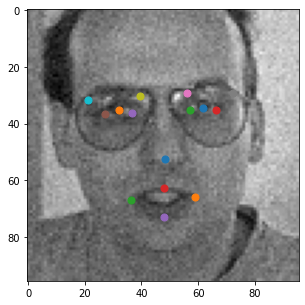

In [34]:
# Plot left rotation for single image
plot_image_with_label_optional(temp_train_img_flat[img_display], temp_train_labels_df.iloc[img_display]).show()

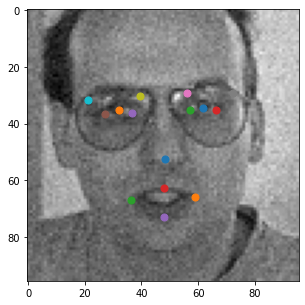

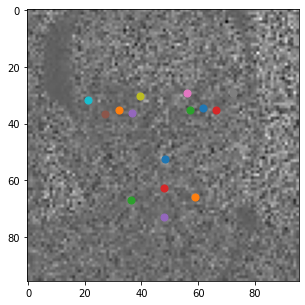

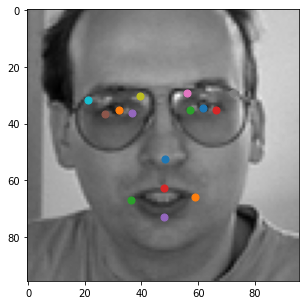

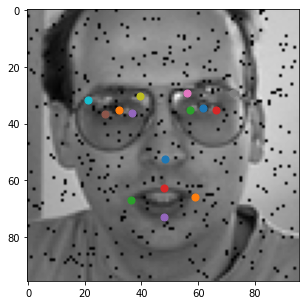

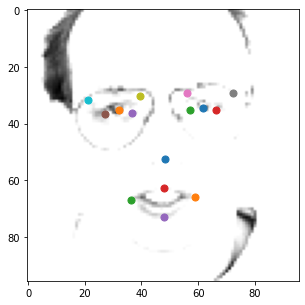

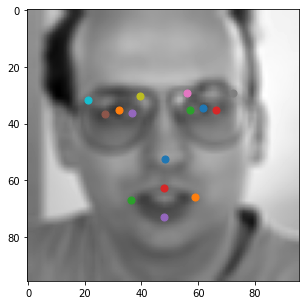

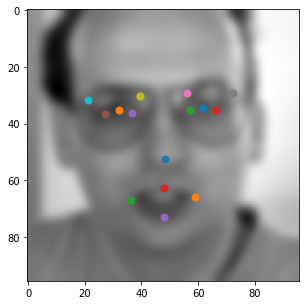

In [35]:
# Display all augmentations for a single image
for i in range(len(aug_list)):
    plot_image_with_label_optional(temp_train_img_2d[img_display + (i*num_train_examples)], temp_train_labels_df.iloc[img_display + (i*num_train_examples)]).show()

## Data Preparation

In [36]:
# We will need to append the augmented data to the end of our training sets (both images and labels)
print(train_images.shape)
print(temp_train_img_flat.shape)
print(type(train_images))
print(type(temp_train_img_flat))

print(train_labels.shape)
print(temp_train_labels_df.shape)
print(type(train_labels))
print(type(temp_train_labels_df))


(7049, 9216)
(49343, 9216)
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(7049, 30)
(49343, 30)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [37]:
temp_train_img_flat = pd.DataFrame(temp_train_img_flat, columns = range(0, IMG_DIM * IMG_DIM))
temp_train_img_flat.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,331.501023,345.445538,326.638381,344.943214,350.192459,355.249102,332.876446,349.916541,339.389332,348.018821,...,139.309695,132.795563,137.507402,130.369380,152.746792,163.038411,165.164219,151.856733,175.618957,184.194803
1,330.569323,316.718160,310.451738,284.500785,299.217469,304.901271,303.567014,308.175098,289.060445,262.856632,...,101.528006,101.773541,84.228673,95.653148,90.632496,81.468955,97.069470,115.915724,92.306305,102.905619
2,245.121575,236.082567,273.574218,280.964732,281.937753,280.728341,284.374014,286.029188,268.541737,235.133498,...,151.855651,137.382642,153.055692,157.926233,193.187509,175.448791,169.563616,166.551863,215.830176,179.971902
3,289.143252,285.199976,299.568268,289.946954,300.678250,275.735565,281.347712,288.306995,276.557775,206.010360,...,102.621015,107.268088,89.867754,91.540008,105.423881,105.380625,87.841761,103.522125,99.614527,88.349649
4,257.277693,262.072383,270.975021,303.553412,329.224836,302.704419,317.828806,318.191149,313.084573,320.776337,...,125.340107,138.025414,132.555927,135.375461,126.765886,154.318534,187.092640,231.667122,280.504126,282.379659


In [38]:
train_images = train_images.append(temp_train_img_flat, ignore_index=True)
train_labels = train_labels.append(temp_train_labels_df, ignore_index=True)

print(train_images.shape)
print(train_labels.shape)

(56392, 9216)
(56392, 30)


In [39]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238.0,236.0,237.0,238.0,240.0,240.0,239.0,241.0,241.0,243.0,...,33.0,29.0,30.0,34.0,39.0,49.0,62.0,70.0,75.0,90.0
1,219.0,215.0,204.0,196.0,204.0,211.0,212.0,200.0,180.0,168.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,144.0,142.0,159.0,180.0,188.0,188.0,184.0,180.0,167.0,132.0,...,64.0,60.0,56.0,61.0,70.0,69.0,71.0,78.0,78.0,77.0
3,193.0,192.0,193.0,194.0,194.0,194.0,193.0,192.0,168.0,111.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,147.0,148.0,160.0,196.0,215.0,214.0,216.0,217.0,219.0,220.0,...,33.0,34.0,37.0,37.0,43.0,46.0,83.0,140.0,170.0,176.0


In [40]:
train_labels.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [41]:
train_images_2d = multiple_img_reshape_2d(train_images)
test_images_2d = multiple_img_reshape_2d(test_images)

print(train_images_2d.shape)
print(test_images_2d.shape)

(56392, 96, 96, 1)
(1783, 96, 96, 1)


**Deep learning models are known to work well with normalized data. Thus we normalize the image pixel values with the highest pixel value intensity, ie, 255. We also normalize the labels with the width of the image size.**

In [42]:
# Normalize train and test data

train_images = train_images / PIX_MAX
test_images = test_images / PIX_MAX
train_images_2d = train_images_2d / PIX_MAX
test_images_2d = test_images_2d / PIX_MAX

train_labels = train_labels / IMG_DIM

In [43]:
# We now have more samples than the standard training set, which will aid us in our training of the model
num_train_examples = train_images.shape[0]
num_train_examples

56392

## Modeling and Training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import optimizers
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
import tensorflow as tf

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),padding='same', use_bias=True ,input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3,3),padding='same', use_bias=True))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='sigmoid'))


model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mse','mae'])


history = model.fit(train_images_2d, train_labels, epochs = 20, batch_size = int(num_train_examples/1000),validation_split = 0.2)


Using TensorFlow backend.


Epoch 1/20
806/806 [==============================] - 11s 13ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0237 - val_loss: 6.9595e-04 - val_mse: 6.9595e-04 - val_mae: 0.0145
Epoch 2/20
806/806 [==============================] - 10s 12ms/step - loss: 7.2798e-04 - mse: 7.2798e-04 - mae: 0.0160 - val_loss: 3.7270e-04 - val_mse: 3.7270e-04 - val_mae: 0.0110
Epoch 3/20
806/806 [==============================] - 10s 12ms/step - loss: 4.2462e-04 - mse: 4.2462e-04 - mae: 0.0123 - val_loss: 2.3591e-04 - val_mse: 2.3591e-04 - val_mae: 0.0089
Epoch 4/20
806/806 [==============================] - 10s 12ms/step - loss: 3.0869e-04 - mse: 3.0869e-04 - mae: 0.0106 - val_loss: 1.8388e-04 - val_mse: 1.8388e-04 - val_mae: 0.0078
Epoch 5/20
806/806 [==============================] - 10s 12ms/step - loss: 2.5237e-04 - mse: 2.5237e-04 - mae: 0.0095 - val_loss: 1.4336e-04 - val_mse: 1.4336e-04 - val_mae: 0.0067
Epoch 6/20
806/806 [==============================] - 10s 12ms/step - loss: 2.1601e-04 - mse: 2.16

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Predict for test
pred = model.predict(test_images_2d)
print(np.min(pred))
print(np.max(pred))
print(np.min(model.predict(train_images_2d)))

## Submission to Kaggle for Scoring

In [ ]:
# Look up table
print(idlookup.head(2))
idlookup = idlookup.drop('Location',axis=1)
print(idlookup.head(2))

In [ ]:
feature_names = train_labels.columns
predictions = pd.DataFrame(pred, columns = feature_names)
predictions = predictions * IMG_DIM

predictions.head()
predictions.stack().reset_index()
predictions = predictions.stack().reset_index()
predictions.columns = ['index','FeatureName','Location']

imageids = test['ImageId']
imageids = imageids.reset_index()

predictions = predictions.merge(imageids, left_on='index', right_on='index')
predictions = predictions.drop('index',axis=1)

predictions

In [ ]:
submission = idlookup.merge(predictions, left_on=['FeatureName','ImageId'], right_on=['FeatureName','ImageId'])
submission = submission[['RowId','Location']]
submission = submission.set_index('RowId')
submission

In [ ]:
# Save submission result
    
if os.getcwd() == CWD:
    os.chdir('/project')
    # make submissions directory if it doesnt exist
    try:
        os.makedirs('submissions')
    except OSError as e:
        pass
    
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S").replace('/','').replace(':','').replace(' ','')
    submission.to_csv('submissions/submission-{0}.csv'.format(dt_string))
    os.chdir(CWD)
    
else:
    submission.to_csv('submission.csv')